1. The Setup (Single Neuron)For a single neuron with two weights $w_1, w_2$ and a bias $b$
Linear Combination ($z$):$$z = w_1x_1 + w_2x_2 + b$$Activation ($a$):$$a = \sigma(z) = \frac{1}{1 + e^{-z}}$$Log Loss ($L$):$$L = -(y \log(a) + (1 - y) \log(1 - a))$$

2. The Chain Rule DerivationTo find the gradient of the loss with respect to the weights, we use the chain rule:Loss w.r.t Activation: $$\frac{\partial L}{\partial a} = \frac{a - y}{a(1 - a)}$$Activation w.r.t Linear Sum: $$\frac{\partial a}{\partial z} = a(1 - a)$$Linear Sum w.r.t Weight: $$\frac{\partial z}{\partial w_1} = x_1$$

Multiplying them together:

$$
\frac{\partial L}{\partial w_1}
=
\frac{\partial L}{\partial a}
\cdot
\frac{\partial a}{\partial z}
\cdot
\frac{\partial z}{\partial w_1}
$$

$$
\frac{\partial L}{\partial w_1}
=
\left[ \frac{a - y}{a(1 - a)} \right]
\cdot
\left[ a(1 - a) \right]
\cdot
x_1
$$


The Final Result:$$\frac{\partial L}{\partial w_1} = (a - y)x_1$$ where a is prediction and y is true label .

3. Vectorization in NumPySince NumPy 1D arrays are flexible, the gradient for the entire weight vector across $n$ samples can be calculated in two ways depending on the position of the error vector.

  Option A:  $X^T$ First (Column Vector Style)If we treat the error as a column, we multiply the transposed feature matrix by the error:$$\frac{\partial L}{\partial w} = \frac{1}{n} X^T (YPredic - Y)$$Dimensions: $(d \times n) \cdot (n \times 1) = (d \times 1)$ where d is features and n is samples
  
  Option B: Error First (Row Vector Style)If we treat the error as a row, we multiply the error by the feature matrix:$$\frac{\partial L}{\partial w} = \frac{1}{n} (YPredic - Y) X$$Dimensions: $(1 \times n) \cdot (n \times d) = (1 \times d)$

The Averaging Logic in Vectorized BackpropagationWhen we compute $\frac{1}{n} X^T (A - Y)$, we are calculating the Mean Gradient for each feature. Here is the expansion for $d$ features and $n$ samples:1. The Vectorized Equation$$\frac{\partial J}{\partial w} = \frac{1}{n} \underbrace{\begin{bmatrix} x_{11} & x_{21} & \cdots & x_{n1} \\ x_{12} & x_{22} & \cdots & x_{n2} \\ \vdots & \vdots & \ddots & \vdots \\ x_{1d} & x_{2d} & \cdots & x_{nd} \end{bmatrix}}_{X^T (d \times n)} \underbrace{\begin{bmatrix} e_1 \\ e_2 \\ \vdots \\ e_n \end{bmatrix}}_{Error (n \times 1)}$$

(Where $e_i = a^{(i)} - y^{(i)}$ is the error for the $i$-th sample)2. The Summation (Feature-wise)After multiplying, the resulting vector contains the sum of (Feature $\times$ Error) for every sample, divided by $n$:$$\frac{\partial J}{\partial w} = \begin{bmatrix} \frac{1}{n} \left( x_{11}e_1 + x_{21}e_2 + \cdots + x_{n1}e_n \right) \\ \frac{1}{n} \left( x_{12}e_1 + x_{22}e_2 + \cdots + x_{n2}e_n \right) \\ \vdots \\ \frac{1}{n} \left( x_{1d}e_1 + x_{2d}e_2 + \cdots + x_{nd}e_n \right) \end{bmatrix}$$


3. Why we divide by $n$ By expanding the first entry (for Feature 1), we see it is literally the average "blame" assigned to Weight 1:$$\frac{\partial J}{\partial w_1} = \frac{\text{Feature}_1 \text{ at Sample}_1 \cdot \text{Error}_1 + \dots + \text{Feature}_1 \text{ at Sample}_n \cdot \text{Error}_n}{n}$$The Logic:If the result is high: This specific feature consistently correlates with our prediction being wrong. Its weight needs a large adjustment.If the result is near zero: On average, this feature doesn't explain the error across the dataset. Its weight stays mostly the same.The Division: Dividing by $n$ ensures that our "adjustment signal" doesn't grow simply because we added more data. It keeps the learning rate ($\alpha$) stable.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def sigmoid(input):
  return 1.0/(1+np.exp(-1.0*input))

  # input will only come as numpy array so no need to make it in numpy

#                                             **CREATING THE NEURONS OR NODE**

In [5]:
class Node:
  def __init__(self,w,b):

# weight = no. of features [w1,w2]
    self.weight = w
    self.bias = b


  def output(self,x):
    #  x is feature matrix [[x1,x2][x3,x4]]
    o = np.dot(self.weight,x.T) + self.bias  # since we are using numpy we can directly add the bias
    return sigmoid(o)
  """Numpy 1D array isn't either a row or col vector .They behave as row vector if multiplied to a matrix from left ,
  otherwise from right , they behave as column vector"""

  def prediction(self,x_test):
    return np.dot(x_test,self.weight)+self.bias
    # Since w is on left , hence it's treated as col vector to obtain w1*x11 + w2 * x12+....

# **CREATING BINARY CROSS ENTROPY AND ACCURACY MEASURING FUNCTIONS**

In [6]:
# logloss for binary prediction called binary cross entropy
def logloss(y_true,y_predic):
  eps = 1e-15
  # Convert all 0's to 1e-15 and all 1's to 1 - 1e-15 otherwise it will made log function to diverge
  y_predic_new = np.array([eps if i == 0 else ((1-eps) if i == 1 else i)for i in y_predic])
  return -np.mean((y_true * np.log(y_predic_new)) + (1-y_true)*np.log(1-y_predic_new ))

In [7]:
def accuracy_measurement(y_pred,y_true):
  y_pred = np.array([1 if i>0.5 else 0 for i in y_pred])
  c = 0
  for i in range(len(y_true)):
    if y_pred[i] == y_true[i]:
      c+=1

  return c/len(y_true)


# **CREATING THE GRADIENT DESCRENT ALGORITHM**

In [8]:
def gradient_descent(x,y_true,epochs,thres,rate):

  w = np.ones(x.shape[1])
  b = 0.0
  n = len(y_true)
# The derivative of logloss gives that w = w - (1/n)*(ypred-y)*x and b = b - mean(ypred-y)

  for i in range(epochs):

    n1 = Node(w,b)
    loss = logloss(y_true,n1.output(x))
    accuracy = accuracy_measurement(n1.output(x),y_true)
    print(f"Epoch {i+1}   Loss {loss}    Accuracy {accuracy} ")

    if loss < thres:
      return w,b

    w = w - rate * (1/n) * np.dot((n1.output(x)-y_true) , x)
    b = b - rate * np.mean(n1.output(x)-y_true)

  return w,b # Return w and b even if threshold is not met

## **For two categorical variable use crosstab, or one categorical and continous variable , use groupby , and for Plotting Bar, just write .plot(kind='bar') at the end .**

,age,affordibility,bought_insurance
0,0.090909,1,0
1,0.159091,0,0
2,0.659091,1,1
3,0.772727,0,0
4,0.636364,1,1


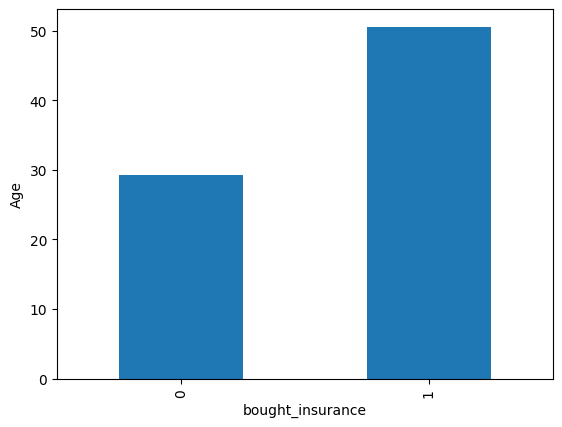

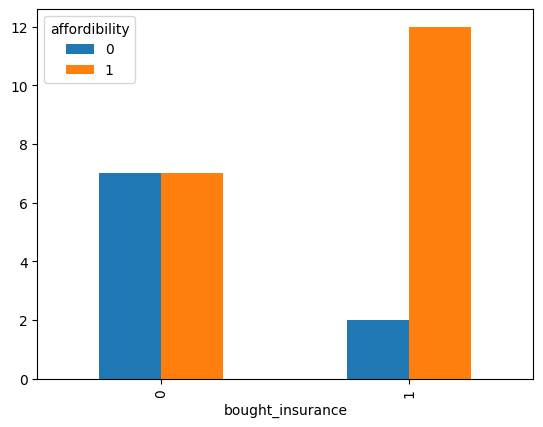

In [10]:
df = pd.read_csv("insurance_data.csv")



df.groupby('bought_insurance')['age'].mean().plot(kind='bar',ylabel = 'Age')

pd.crosstab(df['bought_insurance'],df['affordibility']).plot(kind='bar')

# Scaling

df['age'] = (df['age'] - df['age'].min())/(df['age'].max()-df['age'].min())
df[:5]

# *From the above , we can conclude that People with higher age and more affordability generally brough the Insurance.*

In [12]:
x = df.iloc[:,:-1].to_numpy()
target = df['bought_insurance'].to_numpy()
df.groupby('bought_insurance')['age'].mean()

bought_insurance
0    0.25487
1    0.74026
Name: age, dtype: float64

In [13]:
trainX , trainY , testX , testY = x[:20],target[:20],x[20:],target[20:]
# rate = 0.1, threshold = 0.01 , epochs = 10
weight , bias = gradient_descent(trainX,trainY,1000,0.3,10.8) # Increased learning rate from 0.001 to 0.1

#Accuracy is observed to be improved after Standard Scaling (Value-minimum)/Range

Epoch 1   Loss 0.6549069039182462    Accuracy 0.5 
Epoch 2   Loss 1.0904320344475484    Accuracy 0.5 
Epoch 3   Loss 2.1390804145242006    Accuracy 0.5 
Epoch 4   Loss 0.4959657836382701    Accuracy 0.8 
Epoch 5   Loss 0.7573105766567233    Accuracy 0.65 
Epoch 6   Loss 0.7166273137933997    Accuracy 0.55 
Epoch 7   Loss 1.1534619671461193    Accuracy 0.55 
Epoch 8   Loss 0.47105481672109306    Accuracy 0.8 
Epoch 9   Loss 0.5301424043239893    Accuracy 0.75 
Epoch 10   Loss 0.4242373640069402    Accuracy 0.95 
Epoch 11   Loss 0.4360334390880757    Accuracy 0.8 
Epoch 12   Loss 0.3868436771885696    Accuracy 0.95 
Epoch 13   Loss 0.38496030736975534    Accuracy 0.85 
Epoch 14   Loss 0.3683940457777431    Accuracy 0.95 
Epoch 15   Loss 0.36600180096771057    Accuracy 0.85 
Epoch 16   Loss 0.3605076013224359    Accuracy 0.9 
Epoch 17   Loss 0.3591285863115302    Accuracy 0.85 
Epoch 18   Loss 0.35706879270357916    Accuracy 0.9 
Epoch 19   Loss 0.35634120806939734    Accuracy 0.85 
Epoch

In [15]:
n = Node(weight,bias)
predictions = n.prediction(testX)
print(f"{accuracy_measurement(predictions,testY)*100}%")

87.5%
